# Final Highway Network Experiment Analysis
This one uses the increase_ego_reward_importance setting and estimates the objective weights of the uncontrolled vehicles

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import os
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from src.utils import calc_hypervolume

## Loading the data

In [113]:
def load_merged_dataframe(literal_str):
    file_list = glob.glob(literal_str)
    df = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
    return df

In [114]:
#load the data
#first two configs
summary_files = os.path.join("data/moma_highway_test_final_estimates_weights/", "moma_highway_test_final_estimates_weights*summary.csv")
#detail_files = os.path.join("data/moma_highway_test_final_estimates_weights/", "moma_highway_test_final_estimates_weights*detail_EVALUATION.csv")
loss_files = os.path.join("data/moma_highway_test_final_estimates_weights/", "moma_highway_test_final_estimates_weights*loss.csv")

df_summary = load_merged_dataframe(summary_files)
df_loss = load_merged_dataframe(loss_files)

df_detail = pd.read_csv("data/moma_highway_test_final_estimates_weights/moma_highway_test_final_estimates_weights_merged_detail_EVALUATION.csv")

In [115]:
print("Summary:")
df_summary.info()
print("Detail:")
df_detail.info()
print("Loss")
df_loss.info()

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57600 entries, 0 to 57599
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         57600 non-null  int64  
 1   repetition_number                  57600 non-null  int64  
 2   weight_index                       57600 non-null  int64  
 3   weight_tuple                       57600 non-null  object 
 4   num_iterations                     57600 non-null  int64  
 5   vehicle_id                         57600 non-null  int64  
 6   normalised_speed_reward            57600 non-null  float64
 7   normalised_energy_reward           57600 non-null  float64
 8   raw_speed_reward                   57600 non-null  float64
 9   raw_energy_reward                  57600 non-null  float64
 10  env_config_id                      57600 non-null  int64  
 11  experiment_id                      57600 non-

## Data Preprocessing

In [116]:
def add_cv_ratio(df):
    df["controlled_vehicle_ratio"] = 0.0
    df.loc[df["env_config_id"] == 0, "controlled_vehicle_ratio"] = 2/20
    df.loc[df["env_config_id"] == 1, "controlled_vehicle_ratio"] = 8/20
    df.loc[df["env_config_id"] == 2, "controlled_vehicle_ratio"] = 14/20
    return df

def shorten_reward_structure_names(df):
    #exclude the suffix "reward" for entries the reward structure column
    df["reward_structure"] = df["reward_structure"].apply(lambda row: row.split("_")[0])

    #remap the use_multi_dqn column to explicitly state the employed reward structure
    df["use_multi_dqn"] = df["use_multi_dqn"].astype(str)
    df.loc[df["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
    df.loc[df["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"
    return df

def add_config_names(df):
    df["alg_config"] = df.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["alg_config"].value_counts())

    df["exp_config"] = df.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["exp_config"].value_counts())

    return df

def extend_dataframe(df):
    df = add_cv_ratio(df)
    df = shorten_reward_structure_names(df)
    df = add_config_names(df)
    return df

In [117]:
df_summary = extend_dataframe(df_summary)
df_detail = extend_dataframe(df_detail)
df_loss = extend_dataframe(df_loss)
df_summary["controlled_vehicle_ratio"].value_counts()
df_summary["speed_weight"] = df_summary["weight_index"] / df_summary["weight_index"].max()

alg_config
NS_separated_RS_mean    19200
NS_basic_RS_ego         19200
NS_basic_RS_mean        19200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_ego         11200
CVR_0.7_NS_separated_RS_mean    11200
CVR_0.7_NS_basic_RS_mean        11200
CVR_0.4_NS_separated_RS_mean     6400
CVR_0.4_NS_basic_RS_mean         6400
CVR_0.4_NS_basic_RS_ego          6400
CVR_0.1_NS_basic_RS_ego          1600
CVR_0.1_NS_separated_RS_mean     1600
CVR_0.1_NS_basic_RS_mean         1600
Name: count, dtype: int64
alg_config
NS_separated_RS_mean    1746480
NS_basic_RS_mean        1659040
NS_basic_RS_ego         1411800
Name: count, dtype: int64
exp_config
CVR_0.7_NS_separated_RS_mean    600660
CVR_0.4_NS_separated_RS_mean    600640
CVR_0.7_NS_basic_RS_mean        575040
CVR_0.1_NS_basic_RS_mean        555400
CVR_0.1_NS_separated_RS_mean    545180
CVR_0.1_NS_basic_RS_ego         545060
CVR_0.4_NS_basic_RS_mean        528600
CVR_0.4_NS_basic_RS_ego         437540
CVR_0.7_NS_basic_RS_ego         429200

In [118]:
df_detail["speed_weight"] = df_detail["weight_index"] / df_detail["weight_index"].max()

In [119]:
#exclude the suffix "reward" for entries the reward structure column
df_summary["reward_structure"] = df_summary["reward_structure"].apply(lambda row: row.split("_")[0])

#remap the use_multi_dqn column to explicitly state the employed reward structure
df_summary["use_multi_dqn"] = df_summary["use_multi_dqn"].astype(str)
df_summary.loc[df_summary["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
df_summary.loc[df_summary["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"

In [120]:
print(df_summary["reward_structure"].value_counts())
print(df_summary["use_multi_dqn"].value_counts())

reward_structure
mean    38400
ego     19200
Name: count, dtype: int64
use_multi_dqn
basic        38400
separated    19200
Name: count, dtype: int64


In [121]:
# add experiment configuration name
df_summary["alg_config"] = df_summary.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["alg_config"].value_counts())

df_summary["exp_config"] = df_summary.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["exp_config"].value_counts())

alg_config
NS_separated_RS_mean    19200
NS_basic_RS_ego         19200
NS_basic_RS_mean        19200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_ego         11200
CVR_0.7_NS_separated_RS_mean    11200
CVR_0.7_NS_basic_RS_mean        11200
CVR_0.4_NS_separated_RS_mean     6400
CVR_0.4_NS_basic_RS_mean         6400
CVR_0.4_NS_basic_RS_ego          6400
CVR_0.1_NS_basic_RS_ego          1600
CVR_0.1_NS_separated_RS_mean     1600
CVR_0.1_NS_basic_RS_mean         1600
Name: count, dtype: int64


## Data Analysis

### Pareto front estimation

Text(0.5, 0, 'Normalised Speed Reward')

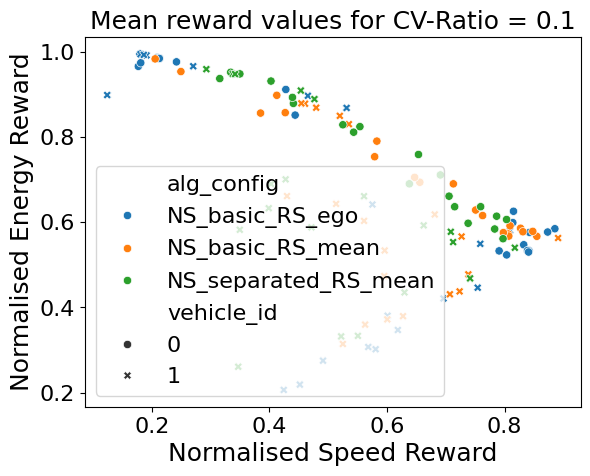

In [122]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward", "normalised_speed_reward"]].mean()
ax = sns.scatterplot(grouped_df, x="normalised_speed_reward", y="normalised_energy_reward", style="vehicle_id",hue="alg_config")
ax.set_title("Mean reward values for CV-Ratio = 0.1")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Normalised Speed Reward")

This plot shows how for this specific cv ratio, the baseline algorithm does best, supposedly because they only care about their own reward. For the mean algo's on the other hand, the vehicle rewards have a lower variance because they care about the rewards of other vehicles as well. If that first impression holds, we will see when looking at the boxplots.

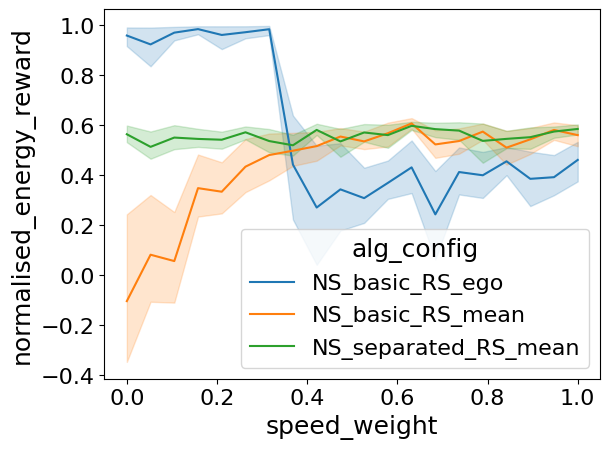

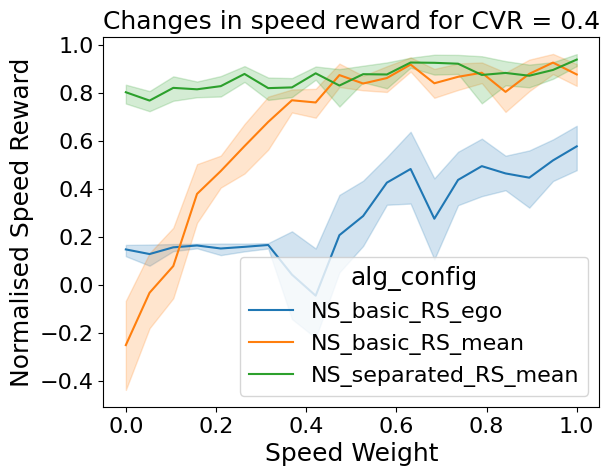

In [123]:
#TODO: two lineplots: one for the energy reward, one for the speeds reward chosing how they change when increasing the preference for speed, i.e. weight index on the x-axis
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.4].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.4")
plt.show()

#0.4 ratio

The ego one does way better than the mean ones in producing very different policies when changing the preferences. This can be attributed to them not caring about other vehicles. The mean ones on the other hand have a much more subtle change in rewards when changing the weight index. This might be caused by several factors. First off, they care about the other vehicle's returns, so they might use different actions because it would increase the mean utility for the close vehicles. Interestingly, when increasing the ratio of vehicles that are controlled to 0.7, the ego algorithm behaves the same, which might be because the controlled vehicles are actually impeding with each other, everyone trying to get out on top (indicated by the high variation is speeds), while the variance for the mean algorithms, the mean separated one in particular, are much lower. This indicates that is has an easier time accurately assessing the social q-values for the close vehicles.

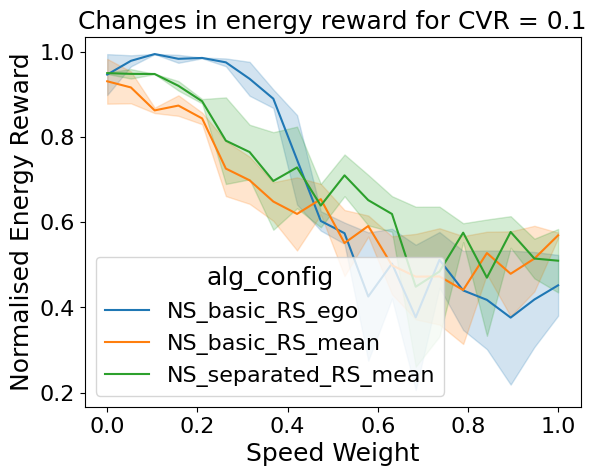

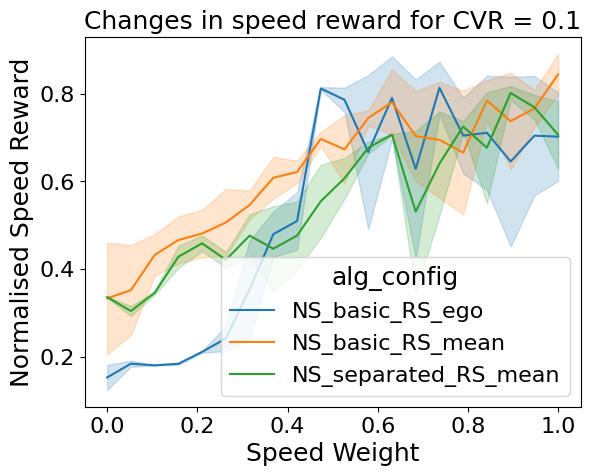

In [124]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in energy reward for CVR = 0.1")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.1")
plt.show()

#0.4 ratio

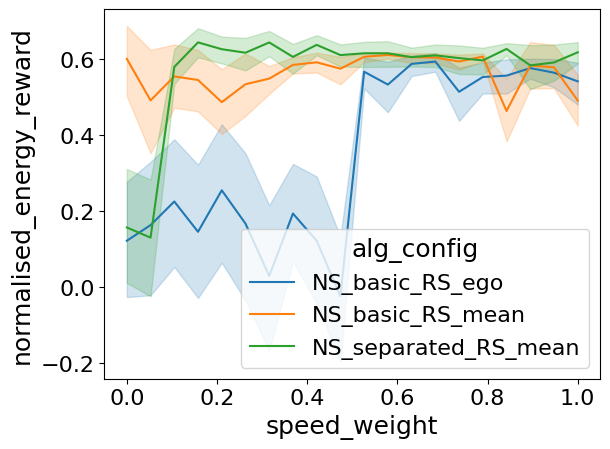

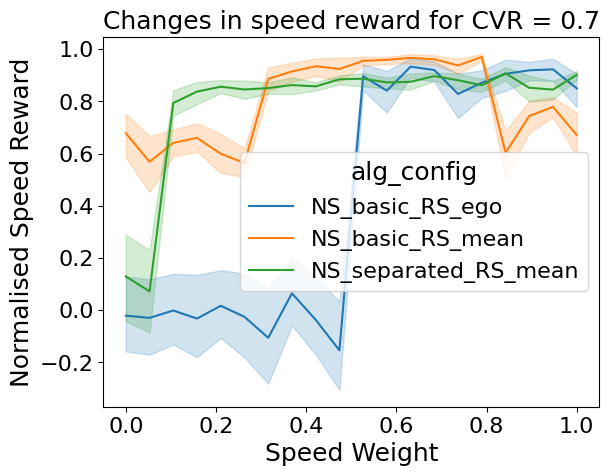

In [125]:
grouped_df = df_summary[(df_summary["controlled_vehicle_ratio"]==0.7)].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.7")
plt.show()
#0.7 ratio

### Speeds instead of speed rewards

In [126]:
df_detail.info()
print(df_detail[df_detail["controlled_flag"] == False]["target_speed"].mean())
print(df_detail[df_detail["controlled_flag"] == False]["target_speed"].std())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4817320 entries, 0 to 4817319
Data columns (total 28 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Unnamed: 0                         int64  
 1   repetition_number                  int64  
 2   weight_index                       int64  
 3   weight_tuple                       object 
 4   iteration                          int64  
 5   vehicle_id                         int64  
 6   controlled_flag                    int64  
 7   action                             float64
 8   target_speed                       float64
 9   curr_speed                         float64
 10  acc                                float64
 11  lane                               int64  
 12  x_pos                              float64
 13  curr_speed_reward                  float64
 14  curr_energy_reward                 float64
 15  env_config_id                      int64  
 16  experiment_id     

In [127]:
grouped_df = df_detail[df_detail["controlled_flag"] == 1].groupby(["controlled_vehicle_ratio", "alg_config", "speed_weight", "vehicle_id"])["curr_speed"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,controlled_vehicle_ratio,alg_config,speed_weight,vehicle_id,curr_speed
0,0.1,NS_basic_RS_ego,0.000000,0,15.255917
1,0.1,NS_basic_RS_ego,0.000000,10,15.250210
2,0.1,NS_basic_RS_ego,0.052632,0,15.231041
3,0.1,NS_basic_RS_ego,0.052632,10,15.222010
4,0.1,NS_basic_RS_ego,0.105263,0,15.277397
...,...,...,...,...,...
1435,0.7,NS_separated_RS_mean,1.000000,15,28.317059
1436,0.7,NS_separated_RS_mean,1.000000,16,28.400846
1437,0.7,NS_separated_RS_mean,1.000000,17,28.287458
1438,0.7,NS_separated_RS_mean,1.000000,18,28.131230


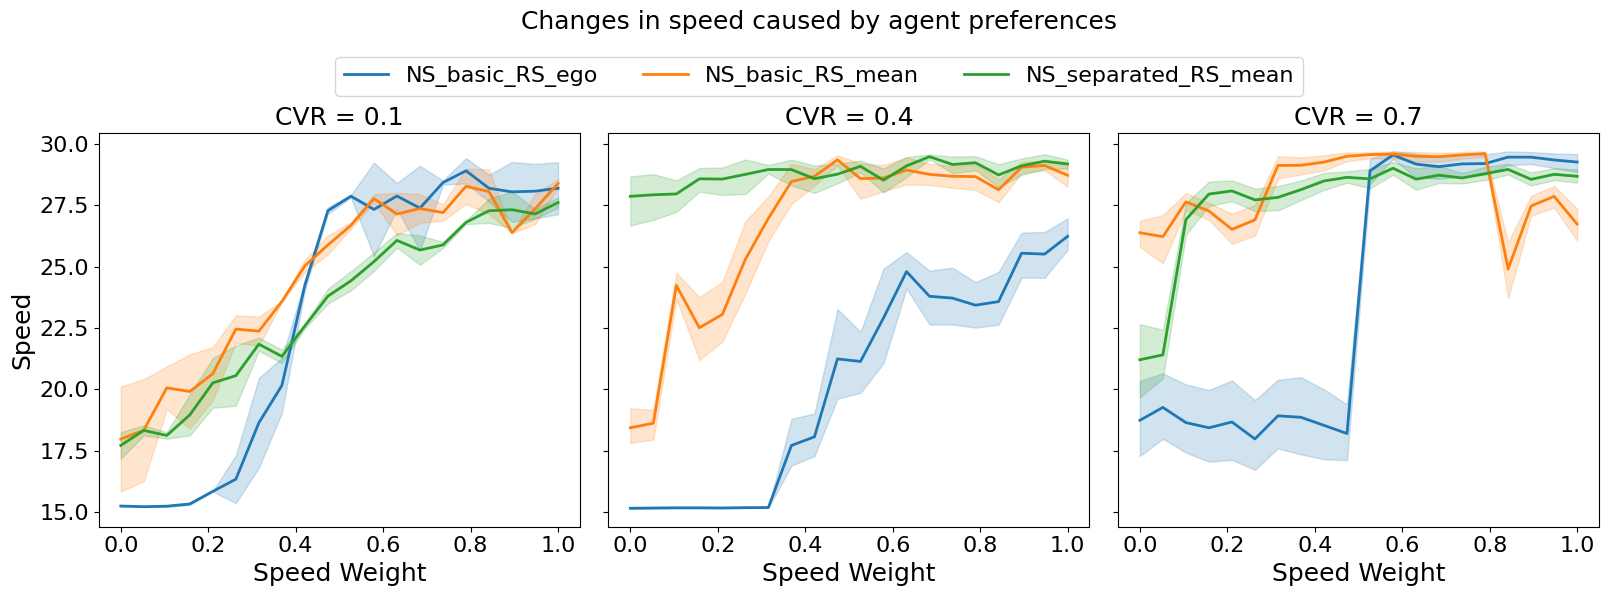

In [128]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(16,6))

data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.1]
ax[0] = sns.lineplot(data, x="speed_weight", y="curr_speed", hue="alg_config", ax=ax[0], linewidth=2)
ax[0].set_ylabel("Speed")
ax[0].set_xlabel("Speed Weight")
ax[0].set_title("CVR = 0.1")

data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.4]
ax[1] = sns.lineplot(data, x="speed_weight", y="curr_speed", hue="alg_config", ax=ax[1], linewidth=2)
ax[1].set_ylabel("Speed")
ax[1].set_xlabel("Speed Weight")
ax[1].set_title("CVR = 0.4")

data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7]
ax[2] = sns.lineplot(data, x="speed_weight", y="curr_speed", hue="alg_config", ax=ax[2], linewidth=2)
ax[2].set_ylabel("Speed")
ax[2].set_xlabel("Speed Weight")
ax[2].set_title("CVR = 0.7")
fig.suptitle("Changes in speed caused by agent preferences")
sns.move_legend(ax[2], "center right")
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Get the handles and labels for the legend
handles, labels = ax[0].get_legend_handles_labels()

# Remove legends from individual plots
for x in ax:
    x.legend_.remove()

# Add a single legend at the top of the figure
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.92))
fig.tight_layout(rect=[0, 0, 1, 0.9])


In [129]:
import matplotlib
matplotlib.rcdefaults()

#### Pivot table

In [130]:
def add_speed_priority_thresholds(datapoint):
    LOW_THRESHOLD = 1/3
    MEDIUM_THRESHOLD = 2/3
    if datapoint <= LOW_THRESHOLD:
        return "LOW"
    if datapoint <= MEDIUM_THRESHOLD:
        return "MEDIUM"
    return "HIGH"

In [131]:
data = df_detail[df_detail["controlled_flag"] == 1].copy()
data["speed_enum"] = data["speed_weight"].apply(add_speed_priority_thresholds)
display(data)

,Unnamed: 0,repetition_number,weight_index,weight_tuple,iteration,vehicle_id,controlled_flag,action,target_speed,curr_speed,...,reward_structure,use_multi_dqn,observation_space_name,increase_ego_reward_importance,estimate_uncontrolled_obj_weights,controlled_vehicle_ratio,alg_config,exp_config,speed_weight,speed_enum
0,0,0,0,"[0.0, 1.0]",0,0,1,2.0,22.5,22.499395,...,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego,0.0,LOW
10,10,0,0,"[0.0, 1.0]",0,10,1,2.0,25.0,24.856919,...,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego,0.0,LOW
20,20,0,0,"[0.0, 1.0]",1,0,1,2.0,22.5,22.499920,...,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego,0.0,LOW
30,30,0,0,"[0.0, 1.0]",1,10,1,2.0,25.0,24.981158,...,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego,0.0,LOW
40,40,0,0,"[0.0, 1.0]",2,0,1,4.0,20.0,20.329208,...,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego,0.0,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817315,600655,19,19,"[1.0, 0.0]",79,15,1,1.0,30.0,30.000000,...,mean,separated,OccupancyGrid,True,True,0.7,NS_separated_RS_mean,CVR_0.7_NS_separated_RS_mean,1.0,HIGH
4817316,600656,19,19,"[1.0, 0.0]",79,16,1,1.0,30.0,30.000000,...,mean,separated,OccupancyGrid,True,True,0.7,NS_separated_RS_mean,CVR_0.7_NS_separated_RS_mean,1.0,HIGH
4817317,600657,19,19,"[1.0, 0.0]",79,17,1,3.0,30.0,30.000000,...,mean,separated,OccupancyGrid,True,True,0.7,NS_separated_RS_mean,CVR_0.7_NS_separated_RS_mean,1.0,HIGH
4817318,600658,19,19,"[1.0, 0.0]",79,18,1,1.0,30.0,30.000000,...,mean,separated,OccupancyGrid,True,True,0.7,NS_separated_RS_mean,CVR_0.7_NS_separated_RS_mean,1.0,HIGH


In [132]:
print("Mean speeds")
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    table = pd.pivot_table(data, values="curr_speed", columns=["controlled_vehicle_ratio","alg_config","speed_enum"], aggfunc="mean")
    display(table)
print("Std speeds")
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    table = pd.pivot_table(data, values="curr_speed", columns=["controlled_vehicle_ratio","alg_config","speed_enum"], aggfunc="std")
    display(table)

Mean speeds


controlled_vehicle_ratio             0.1                        \
alg_config               NS_basic_RS_ego                         
speed_enum                          HIGH        LOW     MEDIUM   
curr_speed                     28.173638  15.985562  25.398428   

controlled_vehicle_ratio                                         \
alg_config               NS_basic_RS_mean                         
speed_enum                           HIGH        LOW     MEDIUM   
curr_speed                      27.561723  20.211656  25.916658   

controlled_vehicle_ratio                                            \
alg_config               NS_separated_RS_mean                        
speed_enum                               HIGH       LOW     MEDIUM   
curr_speed                          26.801988  19.33085  23.899429   

controlled_vehicle_ratio             0.4                       \
alg_config               NS_basic_RS_ego                        
speed_enum                          HIGH       LOW     MEDIUM   
curr_speed                      24.52288  15.17873  20.891253   

controlled_vehicle_ratio                                         \
alg_config               NS_basic_RS_mean                         
speed_enum                           HIGH        LOW     MEDIUM   
curr_speed                      28.725077  22.437487  28.768216   

controlled_vehicle_ratio                                            \
alg_config               NS_separated_RS_mean                        
speed_enum                               HIGH        LOW    MEDIUM   
curr_speed                          29.159585  28.367184  28.83269   

controlled_vehicle_ratio             0.7                        \
alg_config               NS_basic_RS_ego                         
speed_enum                          HIGH        LOW     MEDIUM   
curr_speed                      29.27718  18.671101  25.031215   

controlled_vehicle_ratio                                         \
alg_config               NS_basic_RS_mean                         
speed_enum                           HIGH        LOW     MEDIUM   
curr_speed                      27.961095  27.198646  29.417576   

controlled_vehicle_ratio                                             
alg_config               NS_separated_RS_mean                        
speed_enum                               HIGH        LOW     MEDIUM  
curr_speed                          28.721849  25.926753  28.569514

Std speeds


controlled_vehicle_ratio             0.1                                       \
alg_config               NS_basic_RS_ego                     NS_basic_RS_mean   
speed_enum                          HIGH       LOW    MEDIUM             HIGH   
curr_speed                      4.241552  2.266992  5.049449         4.294761   

controlled_vehicle_ratio                                                     \
alg_config                                   NS_separated_RS_mean             
speed_enum                     LOW    MEDIUM                 HIGH       LOW   
curr_speed                4.059158  4.684238             4.566282  3.378504   

controlled_vehicle_ratio                     0.4                      \
alg_config                       NS_basic_RS_ego                       
speed_enum                MEDIUM            HIGH       LOW    MEDIUM   
curr_speed                4.6328        6.429316  0.895693  6.389553   

controlled_vehicle_ratio                                       \
alg_config               NS_basic_RS_mean                       
speed_enum                           HIGH       LOW    MEDIUM   
curr_speed                       3.637222  6.880258  3.541728   

controlled_vehicle_ratio                                           \
alg_config               NS_separated_RS_mean                       
speed_enum                               HIGH       LOW    MEDIUM   
curr_speed                           2.819678  3.828885  3.345213   

controlled_vehicle_ratio             0.7                                       \
alg_config               NS_basic_RS_ego                     NS_basic_RS_mean   
speed_enum                          HIGH       LOW    MEDIUM             HIGH   
curr_speed                      2.761001  5.916699  6.732327          4.06089   

controlled_vehicle_ratio                                                    \
alg_config                                   NS_separated_RS_mean            
speed_enum                     LOW    MEDIUM                 HIGH      LOW   
curr_speed                4.623083  2.322992             2.940922  5.71376   

controlled_vehicle_ratio            
alg_config                          
speed_enum                  MEDIUM  
curr_speed                3.181491

### Speed over time

In [133]:
grouped_df = df_detail[df_detail["controlled_flag"] == 1].groupby(["controlled_vehicle_ratio", "alg_config", "speed_weight", "vehicle_id", "iteration"])["curr_speed"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,controlled_vehicle_ratio,alg_config,speed_weight,vehicle_id,iteration,curr_speed
0,0.1,NS_basic_RS_ego,0.0,0,0,21.923382
1,0.1,NS_basic_RS_ego,0.0,0,1,21.013059
2,0.1,NS_basic_RS_ego,0.0,0,2,19.265094
3,0.1,NS_basic_RS_ego,0.0,0,3,17.406823
4,0.1,NS_basic_RS_ego,0.0,0,4,15.751104
...,...,...,...,...,...,...
115195,0.7,NS_separated_RS_mean,1.0,19,75,30.000000
115196,0.7,NS_separated_RS_mean,1.0,19,76,30.000000
115197,0.7,NS_separated_RS_mean,1.0,19,77,30.000000
115198,0.7,NS_separated_RS_mean,1.0,19,78,30.000000


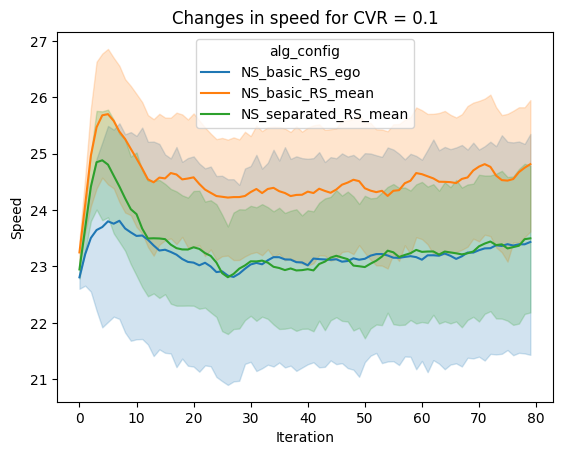

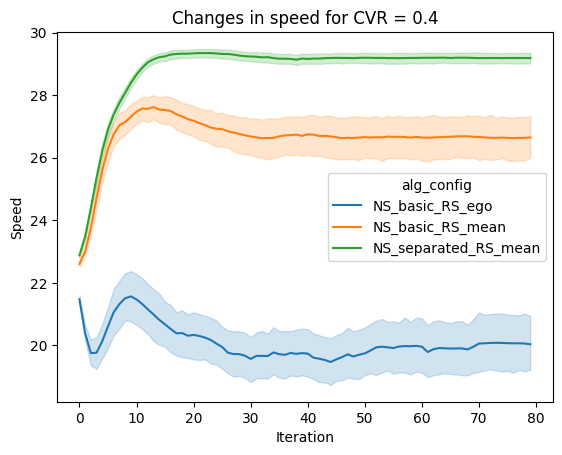

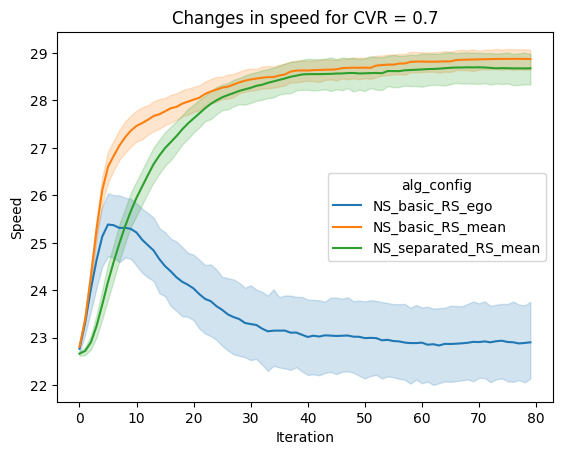

In [134]:
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.1]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Changes in speed for CVR = 0.1")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.4]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Changes in speed for CVR = 0.4")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Changes in speed for CVR = 0.7")
plt.show()

### Number of iterations before crash

/tmp/ipykernel_4257/3133461468.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(round(float(label), 2)*100)) for label in labels])


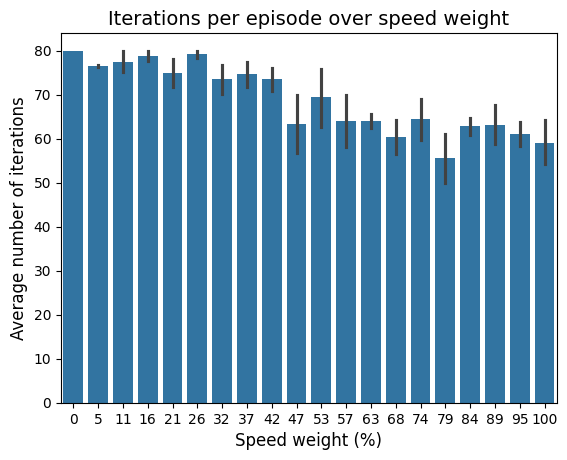

In [135]:
#TODO: num iterations before a crash
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","speed_weight", "vehicle_id"])[["num_iterations"]].mean()
ax = sns.barplot(grouped_df, x="speed_weight", y="num_iterations")
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(int(round(float(label), 2)*100)) for label in labels])
plt.title("Iterations per episode over speed weight", fontsize=14)
plt.xlabel("Speed weight (%)", fontsize=12)
plt.ylabel("Average number of iterations", fontsize=12)
plt.show()

In [136]:
#TODO: num iterations before a crash
data = df_summary.copy()
data["speed_enum"] = data["speed_weight"].apply(add_speed_priority_thresholds)
data["crashed"] = data["num_iterations"] < 80
sum_table = pd.pivot_table(data, values="crashed", columns=["controlled_vehicle_ratio", "alg_config", "speed_enum"], aggfunc="sum")
count_table = pd.pivot_table(data, values="crashed", columns=["controlled_vehicle_ratio", "alg_config", "speed_enum"], aggfunc="count")
ratio_table = (sum_table / count_table)*100

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    #Ratio table
    display(ratio_table)

controlled_vehicle_ratio             0.1                       \
alg_config               NS_basic_RS_ego                        
speed_enum                          HIGH       LOW     MEDIUM   
crashed                        40.714286  1.428571  28.333333   

controlled_vehicle_ratio                                        \
alg_config               NS_basic_RS_mean                        
speed_enum                           HIGH       LOW     MEDIUM   
crashed                         24.285714  5.714286  20.833333   

controlled_vehicle_ratio                                            \
alg_config               NS_separated_RS_mean                        
speed_enum                               HIGH       LOW     MEDIUM   
crashed                             42.142857  6.428571  21.666667   

controlled_vehicle_ratio             0.4                                   \
alg_config               NS_basic_RS_ego                 NS_basic_RS_mean   
speed_enum                          HIGH  LOW     MEDIUM             HIGH   
crashed                        73.571429  0.0  68.333333        11.428571   

controlled_vehicle_ratio                                             \
alg_config                                     NS_separated_RS_mean   
speed_enum                      LOW     MEDIUM                 HIGH   
crashed                   41.428571  15.833333            11.428571   

controlled_vehicle_ratio                                   0.7             \
alg_config                                     NS_basic_RS_ego              
speed_enum                      LOW     MEDIUM            HIGH        LOW   
crashed                   12.857143  10.833333       15.714286  87.857143   

controlled_vehicle_ratio                                               \
alg_config                      NS_basic_RS_mean                        
speed_enum               MEDIUM             HIGH        LOW    MEDIUM   
crashed                    45.0             15.0  32.142857  9.166667   

controlled_vehicle_ratio                                        
alg_config               NS_separated_RS_mean                   
speed_enum                               HIGH       LOW MEDIUM  
crashed                              7.142857  9.285714    7.5

/tmp/ipykernel_4257/1327482625.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(round(float(label), 2)*100)) for label in labels])


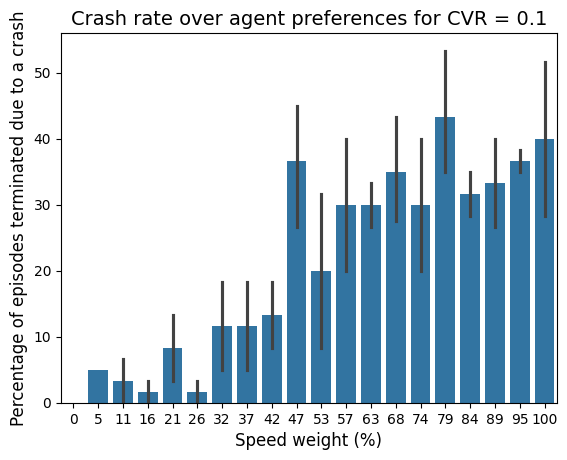

In [137]:
grouped = data[data["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","speed_weight", "vehicle_id"])
data = grouped[["crashed"]].sum() / grouped[["crashed"]].count() * 100
ax = sns.barplot(data, x="speed_weight", y="crashed")
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(int(round(float(label), 2)*100)) for label in labels])
plt.title("Crash rate over agent preferences for CVR = 0.1", fontsize=14)
plt.xlabel("Speed weight (%)", fontsize=12)
plt.ylabel("Percentage of episodes terminated due to a crash", fontsize=12)
plt.show()

### Plots of hypervolume distribution among vehicles of the same experiment

In [138]:
#compute hypervolume for all vehicles
hv_data = []
grouped_data = df_summary.groupby(["controlled_vehicle_ratio","alg_config","vehicle_id"])
for (cvr, alg_config, vehicle_id), group in grouped_data:
    group_data = group[["normalised_speed_reward","normalised_energy_reward"]].to_numpy()
    hv = calc_hypervolume(reward_vector=group_data)
    hv_data.append({"controlled_vehicle_ratio": cvr, "alg_config":alg_config, "vehicle_id": vehicle_id, "hypervolume":hv})

hv_df = pd.DataFrame(hv_data)
display(hv_df)
#TODO: construct scatterplot and then boxplot of the hypervolumes for the vehicles grouped by ratio of controlled vehicles and by reward/network structure
#compute hypervolume



,controlled_vehicle_ratio,alg_config,vehicle_id,hypervolume
0,0.1,NS_basic_RS_ego,0,0.818810
1,0.1,NS_basic_RS_ego,1,0.815884
2,0.1,NS_basic_RS_mean,0,0.812696
3,0.1,NS_basic_RS_mean,1,0.819680
4,0.1,NS_separated_RS_mean,0,0.816193
...,...,...,...,...
67,0.7,NS_separated_RS_mean,9,0.795647
68,0.7,NS_separated_RS_mean,10,0.808525
69,0.7,NS_separated_RS_mean,11,0.795278
70,0.7,NS_separated_RS_mean,12,0.822367


In [139]:
data = hv_df.copy()
mean_table = pd.pivot_table(data, values="hypervolume", columns=["controlled_vehicle_ratio", "alg_config"], aggfunc="mean")
std_table = pd.pivot_table(data, values="hypervolume", columns=["controlled_vehicle_ratio", "alg_config"], aggfunc="std")
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    #Ratio table
    print("mean table")
    display(mean_table)
    print("std table")
    display(std_table)


mean table


controlled_vehicle_ratio             0.1                   \
alg_config               NS_basic_RS_ego NS_basic_RS_mean   
hypervolume                     0.817347         0.816188   

controlled_vehicle_ratio                                  0.4  \
alg_config               NS_separated_RS_mean NS_basic_RS_ego   
hypervolume                          0.827447        0.824669   

controlled_vehicle_ratio                                        \
alg_config               NS_basic_RS_mean NS_separated_RS_mean   
hypervolume                      0.822201             0.766802   

controlled_vehicle_ratio             0.7                                        
alg_config               NS_basic_RS_ego NS_basic_RS_mean NS_separated_RS_mean  
hypervolume                     0.804945         0.820398             0.800545

std table


controlled_vehicle_ratio             0.1                   \
alg_config               NS_basic_RS_ego NS_basic_RS_mean   
hypervolume                     0.002069         0.004939   

controlled_vehicle_ratio                                  0.4  \
alg_config               NS_separated_RS_mean NS_basic_RS_ego   
hypervolume                          0.015916        0.004796   

controlled_vehicle_ratio                                        \
alg_config               NS_basic_RS_mean NS_separated_RS_mean   
hypervolume                      0.008246             0.034798   

controlled_vehicle_ratio             0.7                                        
alg_config               NS_basic_RS_ego NS_basic_RS_mean NS_separated_RS_mean  
hypervolume                     0.034177         0.009337             0.028014

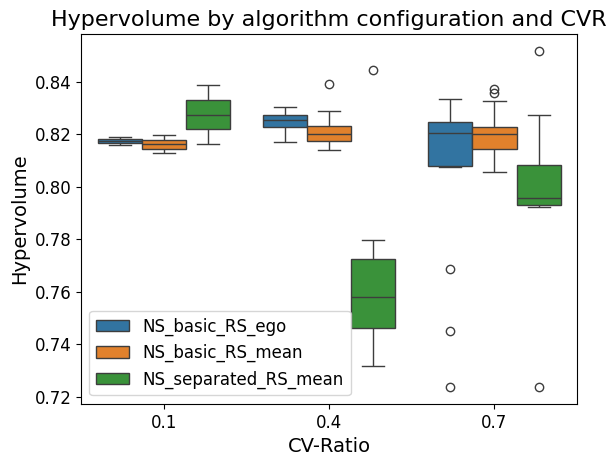

In [140]:
ax = sns.boxplot(hv_df, x="controlled_vehicle_ratio", y="hypervolume", hue="alg_config")
ax.set_ylabel("Hypervolume", fontsize=14)
ax.set_xlabel("CV-Ratio", fontsize=14)
ax.set_title("Hypervolume by algorithm configuration and CVR", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
plt.show()

#TODO: hypothesis: the hypervolume is dependent on the vehicle id, 
# because of they way they are spawned (one vehicle is always first, 
# has an easier time optimising their reward as they don't have as many vehicles to overtake): 
# color the dots in the scatterplot by the vehicle_id to see if there is. 
# If that is to messy to see something, try using a barplot/lineplot 
# with the vehicle ID on the x axis and the hypervolume on the y axis

<Axes: xlabel='vehicle_id', ylabel='hypervolume'>

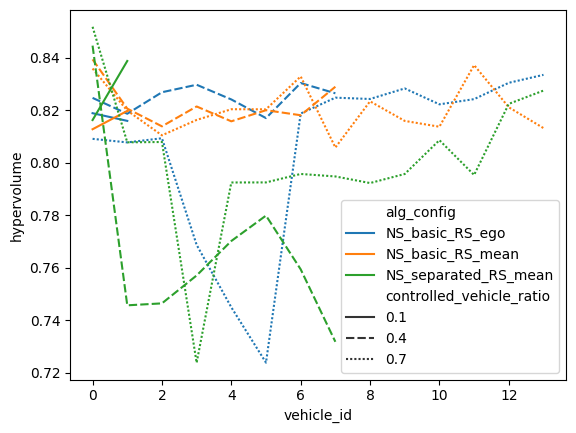

In [141]:
sns.lineplot(hv_df, x="vehicle_id", y="hypervolume", hue="alg_config", style="controlled_vehicle_ratio")

### Loss analysis

In [142]:
df_loss

,Unnamed: 0,episode,loss,hypervolume,avg_num_iterations_training,std_num_iterations_training,env_config_id,experiment_id,replay_buffer_size,batch_size,reward_structure,use_multi_dqn,observation_space_name,increase_ego_reward_importance,estimate_uncontrolled_obj_weights,controlled_vehicle_ratio,alg_config,exp_config
0,0,NaN,NaN,0.254176,53.28,30.647278,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
1,1,1.0,0.294652,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
2,2,2.0,0.312252,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
3,3,3.0,0.301577,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
4,4,4.0,0.350730,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,1995,1995.0,0.961836,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego
35996,1996,1996.0,0.915382,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego
35997,1997,1997.0,0.900421,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego
35998,1998,1998.0,0.831152,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego


In [143]:
#TODO: look at how the loss (and maybe the hypervolume) changes while training for all the algorithm configurations
grouped_df = df_loss.groupby(["alg_config", "controlled_vehicle_ratio", "episode"])["loss"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_vehicle_ratio,episode,loss
0,NS_basic_RS_ego,0.1,0.0,0.264225
1,NS_basic_RS_ego,0.1,1.0,0.311265
2,NS_basic_RS_ego,0.1,2.0,0.388571
3,NS_basic_RS_ego,0.1,3.0,0.459752
4,NS_basic_RS_ego,0.1,4.0,0.709059
...,...,...,...,...
17992,NS_separated_RS_mean,0.7,1995.0,0.895188
17993,NS_separated_RS_mean,0.7,1996.0,0.961141
17994,NS_separated_RS_mean,0.7,1997.0,1.334000
17995,NS_separated_RS_mean,0.7,1998.0,1.284112


<Axes: xlabel='episode', ylabel='loss'>

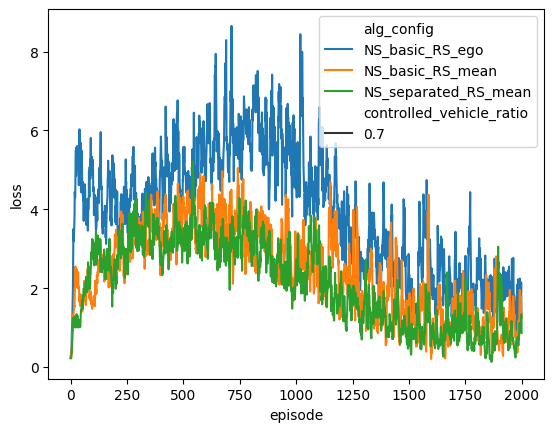

In [144]:
sns.lineplot(grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7], x="episode", y="loss", hue="alg_config", style="controlled_vehicle_ratio")

### Detail df analysis

In [145]:
df_detail["speed_diff"] = np.abs(df_detail["target_speed"] - df_detail["curr_speed"])
df_detail["abs_acc"] = np.abs(df_detail["acc"])
#df_detail.info()
display(df_detail[["lane","x_pos","curr_speed_reward"]])

,lane,x_pos,curr_speed_reward
0,2,185.486633,0.526222
1,2,210.228660,NaN
2,0,230.679316,NaN
3,1,254.016444,NaN
4,0,272.881656,NaN
...,...,...,...
4817315,3,2957.835444,1.000000
4817316,3,2970.932085,1.000000
4817317,3,2986.455371,1.000000
4817318,3,2997.281992,1.000000


## speeds for high cv ratio before and after passing the first controlled vehicle

In [146]:
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4817320 entries, 0 to 4817319
Data columns (total 30 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Unnamed: 0                         int64  
 1   repetition_number                  int64  
 2   weight_index                       int64  
 3   weight_tuple                       object 
 4   iteration                          int64  
 5   vehicle_id                         int64  
 6   controlled_flag                    int64  
 7   action                             float64
 8   target_speed                       float64
 9   curr_speed                         float64
 10  acc                                float64
 11  lane                               int64  
 12  x_pos                              float64
 13  curr_speed_reward                  float64
 14  curr_energy_reward                 float64
 15  env_config_id                      int64  
 16  experiment_id     

In [147]:
file_location = "data/df_detail_overtaking.csv"
do_again = False
if not os.path.isfile(file_location) or do_again:
    df = df_detail[(df_detail["controlled_vehicle_ratio"]==0.7) & (df_detail["speed_weight"] <= 0.5)].copy()
    df = df.sort_values(by=['alg_config', 'speed_weight', 'repetition_number', 'iteration'])
    # Step 2: Initialize the 'overtake' column with False
    df['overtake'] = False
    # Step 3: Check for overtakes
    # Group by alg_config and episode to handle each episode separately
    grouped = df.groupby(['controlled_vehicle_ratio', 'alg_config', 'speed_weight', 'repetition_number'])

    # Function to detect overtakes for each group
    def detect_overtakes(group):
        vehicles = group['vehicle_id'].unique()
        vehicles = set(vehicles)
        num_iterations = group["iteration"].max()
        controlled_vehicles = group[group["controlled_flag"] == 1]["vehicle_id"].unique()
        for v1 in controlled_vehicles:
            other_vehicles = vehicles.copy()
            other_vehicles.remove(v1)
            overtaken = False
            for v2 in other_vehicles:
                for i in range(1,num_iterations):
                    v1_prev = group[(group['vehicle_id'] == v1) & (group['iteration'] == i-1)]
                    v2_prev = group[(group['vehicle_id'] == v2) & (group['iteration'] == i-1)]
                    v1_curr = group[(group['vehicle_id'] == v1) & (group['iteration'] == i)]
                    v2_curr = group[(group['vehicle_id'] == v2) & (group['iteration'] == i)]
                
                    if v1_prev['x_pos'].values[0] <= v2_prev['x_pos'].values[0] and v1_curr['x_pos'].values[0] > v2_curr['x_pos'].values[0]:
                        group.loc[v1_curr.index, 'overtake'] = True
                        overtaken = True
                        break
                if overtaken:
                    break

        return group

    # Apply the function to each group
    df = grouped.apply(detect_overtakes)
    df.to_csv(file_location)
else:
    df = pd.read_csv(file_location)
# Reset the index if necessary

In [148]:
display(df["overtake"].value_counts())

overtake
False    728158
True       3982
Name: count, dtype: int64

In [149]:

def modify_iteration_values(group):
    if group["overtake"].any():
        overtake_iteration = group[group["overtake"] == True]["iteration"].values[0]
        group["relative_iteration"] = group["iteration"] - overtake_iteration
    return group

df["relative_iteration"] = np.nan
df = df[df["controlled_flag"] == 1]
grouped = df.groupby(['controlled_vehicle_ratio', 'alg_config', 'speed_weight', 'repetition_number', "vehicle_id"])
df = grouped.apply(modify_iteration_values)

/tmp/ipykernel_4257/629819019.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(modify_iteration_values)


In [150]:
df["reward_structure"].value_counts()

reward_structure
mean    396998
ego     115500
Name: count, dtype: int64

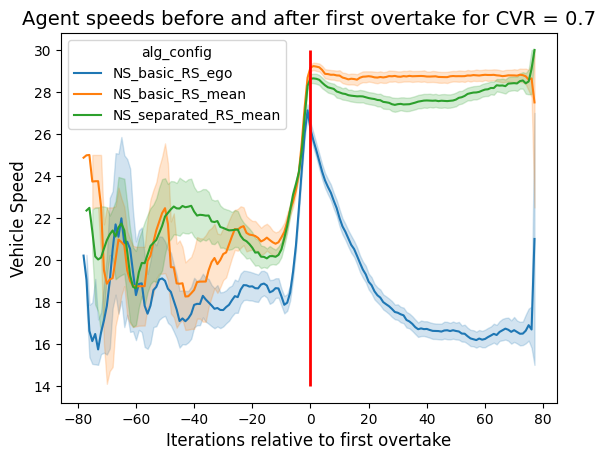

In [151]:
df = df[~df["relative_iteration"].isna()]
#df = df[df["reward_structure"] == "mean"]
df = df.reset_index(drop=True)
grouped = df.groupby(['controlled_vehicle_ratio', 'alg_config', 'speed_weight', 'repetition_number', "vehicle_id","relative_iteration"])
data = grouped["curr_speed"].mean()
data = data.reset_index()
ax = sns.lineplot(data, x="relative_iteration", y="curr_speed", hue="alg_config")
ax.vlines(x=0, ymin=14, ymax=30, color="r", linewidth=2)
plt.xlabel("Iterations relative to first overtake", fontsize=12)
plt.ylabel("Vehicle Speed", fontsize=12)
plt.title("Agent speeds before and after first overtake for CVR = 0.7", fontsize=14)
plt.savefig("img/agent_speed_overtake.pdf", format="pdf")
plt.show()

In [152]:
grouped_df = df_detail.groupby(["alg_config","controlled_flag", "controlled_vehicle_ratio", "repetition_number","iteration"])["abs_acc"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_flag,controlled_vehicle_ratio,repetition_number,iteration,abs_acc
0,NS_basic_RS_ego,0,0.1,0,0,1.261850e+00
1,NS_basic_RS_ego,0,0.1,0,1,5.235028e-01
2,NS_basic_RS_ego,0,0.1,0,2,3.707325e-01
3,NS_basic_RS_ego,0,0.1,0,3,2.835075e-01
4,NS_basic_RS_ego,0,0.1,0,4,2.275756e-01
...,...,...,...,...,...,...
28795,NS_separated_RS_mean,1,0.7,19,75,5.872853e-15
28796,NS_separated_RS_mean,1,0.7,19,76,5.872853e-15
28797,NS_separated_RS_mean,1,0.7,19,77,5.872853e-15
28798,NS_separated_RS_mean,1,0.7,19,78,5.872853e-15


### uncontrolled vehicles

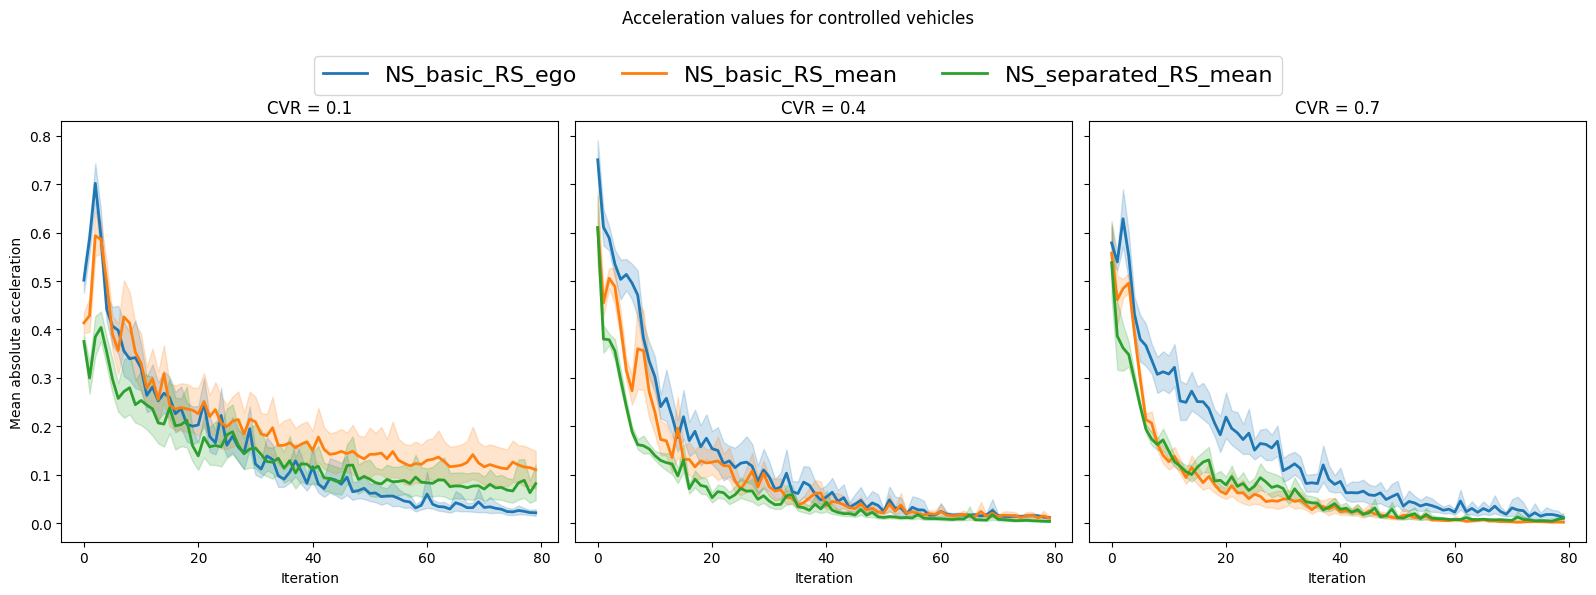

In [153]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(16,6))

data = grouped_df[grouped_df["controlled_flag"] == 1]
ax[0] = sns.lineplot(data, x="iteration", y="abs_acc", hue="alg_config", ax=ax[0], linewidth=2)
ax[0].set_ylabel("Mean absolute acceleration")
ax[0].set_xlabel("Iteration")
ax[0].set_title("CVR = 0.1")

data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.4]
ax[1] = sns.lineplot(data, x="iteration", y="abs_acc", hue="alg_config", ax=ax[1], linewidth=2)
ax[1].set_ylabel("Mean absolute acceleration")
ax[1].set_xlabel("Iteration")
ax[1].set_title("CVR = 0.4")

data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7]
ax[2] = sns.lineplot(data, x="iteration", y="abs_acc", hue="alg_config", ax=ax[2], linewidth=2)
ax[2].set_ylabel("Mean absolute acceleration")
ax[2].set_xlabel("Iteration")
ax[2].set_title("CVR = 0.7")
fig.suptitle("Acceleration values for controlled vehicles")
sns.move_legend(ax[2], "center right")
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Get the handles and labels for the legend
handles, labels = ax[0].get_legend_handles_labels()

# Remove legends from individual plots
for x in ax:
    x.legend_.remove()

# Add a single legend at the top of the figure
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.92))
fig.tight_layout(rect=[0, 0, 1, 0.9])


In [154]:
matplotlib.rcdefaults()

### speed

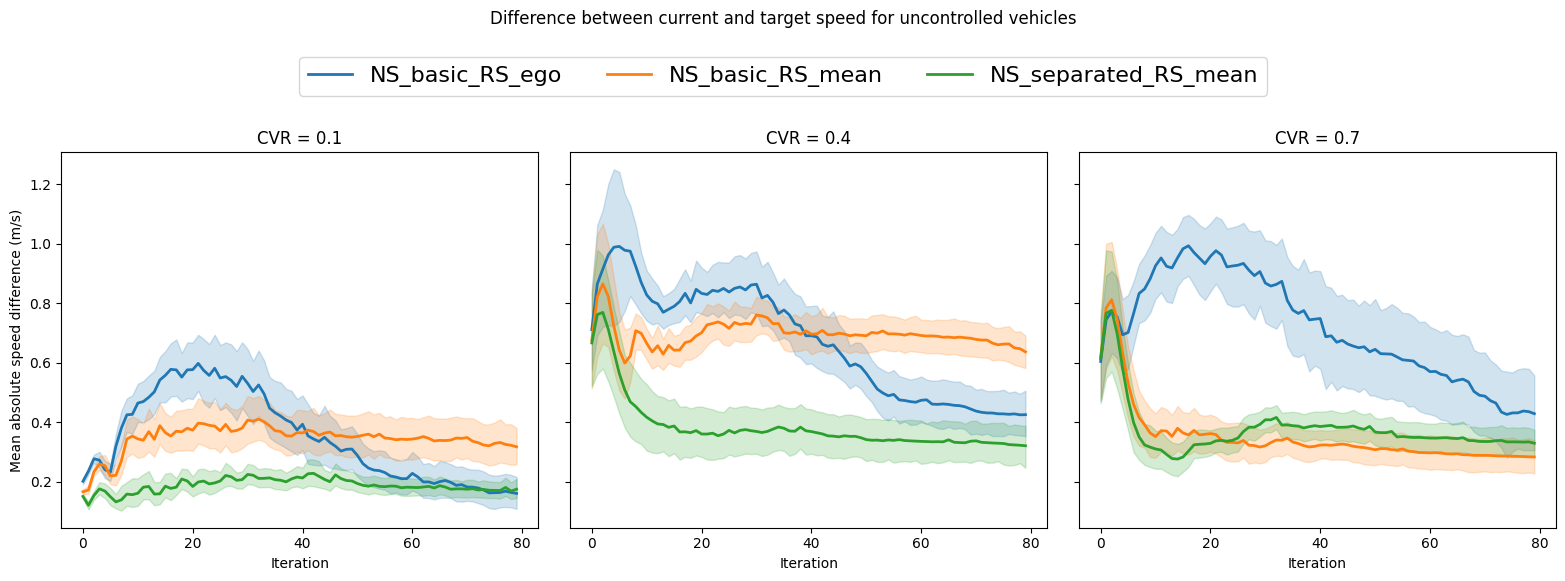

In [155]:
grouped_df = df_detail.groupby(["alg_config","controlled_flag", "controlled_vehicle_ratio", "repetition_number","iteration"])["speed_diff"].mean()
grouped_df = grouped_df.reset_index()

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(16,6))
data = grouped_df[grouped_df["controlled_flag"] == 1]
ax[0] = sns.lineplot(data, x="iteration", y="speed_diff", hue="alg_config", ax=ax[0], linewidth=2)
ax[0].set_ylabel("Mean absolute speed difference (m/s)")
ax[0].set_xlabel("Iteration")
ax[0].set_title("CVR = 0.1")

data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.4]
ax[1] = sns.lineplot(data, x="iteration", y="speed_diff", hue="alg_config", ax=ax[1], linewidth=2)
ax[1].set_ylabel("Mean absolute speed difference (m/s)")
ax[1].set_xlabel("Iteration")
ax[1].set_title("CVR = 0.4")

data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7]
ax[2] = sns.lineplot(data, x="iteration", y="speed_diff", hue="alg_config", ax=ax[2], linewidth=2)
ax[2].set_ylabel("Mean absolute speed difference (m/s)")
ax[2].set_xlabel("Iteration")
ax[2].set_title("CVR = 0.7")
fig.suptitle("Difference between current and target speed for uncontrolled vehicles")
sns.move_legend(ax[2], "center right")
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Get the handles and labels for the legend
handles, labels = ax[0].get_legend_handles_labels()

# Remove legends from individual plots
for x in ax:
    x.legend_.remove()

# Add a single legend at the top of the figure
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.92))
fig.tight_layout(rect=[0, 0, 1, 0.9])
#plt.xlabel("Iteration", fontsize=12)
#plt.ylabel("Mean absolute speed difference (m/s)", fontsize=12)
#plt.title("Difference between current and target speed for uncontrolled vehicles", fontsize=14)
plt.savefig("img/human_vehicles_speed_diff.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [156]:
matplotlib.rcdefaults()

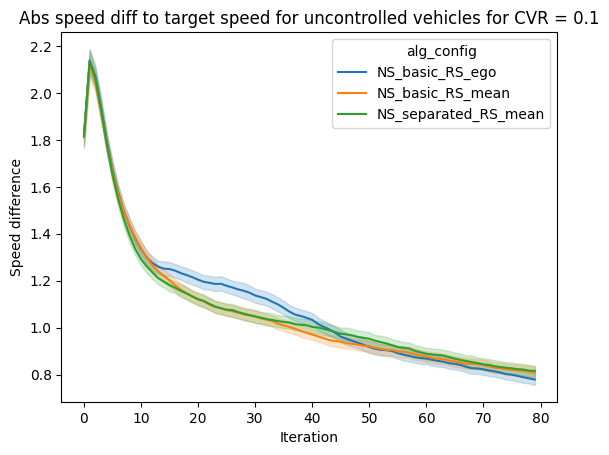

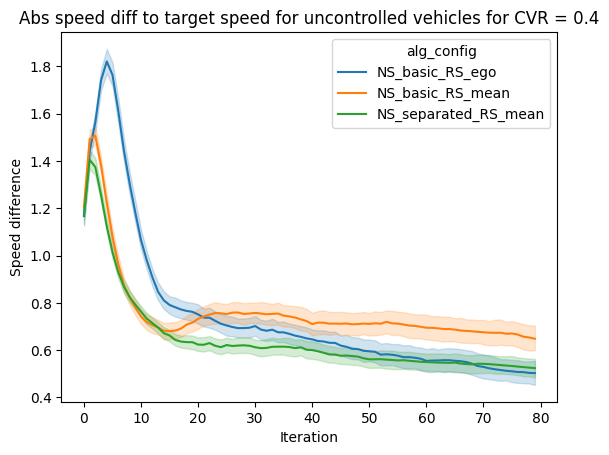

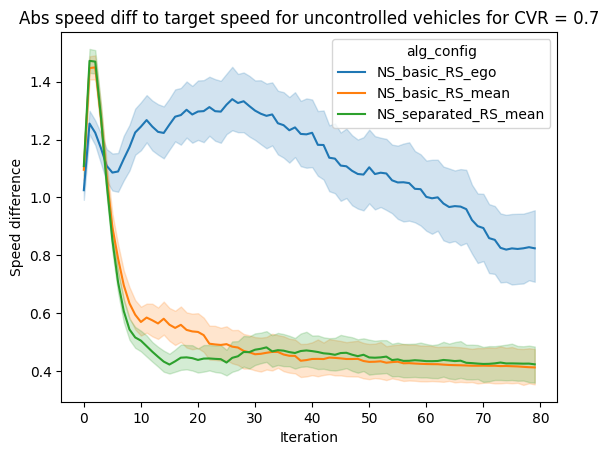

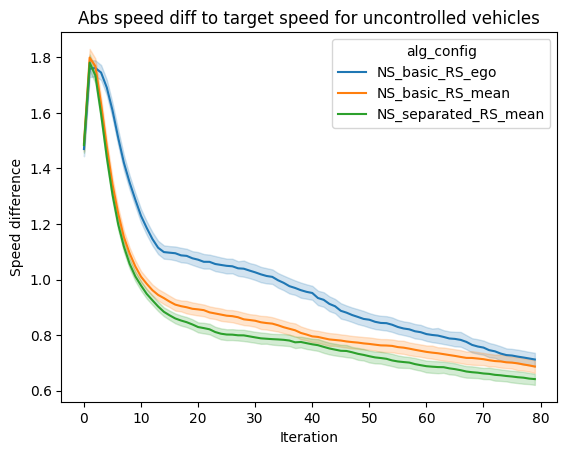

In [157]:
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0) & (df_detail["controlled_vehicle_ratio"] == 0.1)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles for CVR = 0.1")
plt.show()
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0) & (df_detail["controlled_vehicle_ratio"] == 0.4)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles for CVR = 0.4")
plt.show()
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0) & (df_detail["controlled_vehicle_ratio"] == 0.7)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles for CVR = 0.7")
plt.show()

#averaged over all cv ratios
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles")
plt.show()

## Lanes

In [158]:
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4817320 entries, 0 to 4817319
Data columns (total 30 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Unnamed: 0                         int64  
 1   repetition_number                  int64  
 2   weight_index                       int64  
 3   weight_tuple                       object 
 4   iteration                          int64  
 5   vehicle_id                         int64  
 6   controlled_flag                    int64  
 7   action                             float64
 8   target_speed                       float64
 9   curr_speed                         float64
 10  acc                                float64
 11  lane                               int64  
 12  x_pos                              float64
 13  curr_speed_reward                  float64
 14  curr_energy_reward                 float64
 15  env_config_id                      int64  
 16  experiment_id     

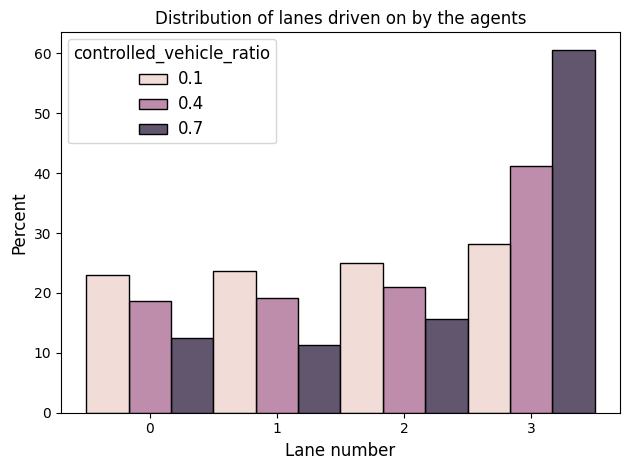

In [159]:
grouped_df = df_detail[df_detail["controlled_flag"] == 1].groupby(["alg_config", "controlled_vehicle_ratio", "speed_weight", "repetition_number", "iteration"])["lane"].max()
grouped_df = grouped_df.reset_index()

ax = sns.histplot(df_detail, x="lane", stat="percent", discrete=True, hue="controlled_vehicle_ratio", multiple='dodge', common_norm=False)
ax.set_xticks(range(4))
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.xlabel("Lane number", fontsize=12)
plt.ylabel("Percent", fontsize=12)
plt.title("Distribution of lanes driven on by the agents")
plt.tight_layout()
plt.savefig("img/lane_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()